# Correlations between CIELAB values, and projecting in LCh space

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind

# for converting cielab to LCh
from colormath.color_objects import LabColor, LCHabColor
from colormath.color_conversions import convert_color

# for the 3d histogram
from mpl_toolkits.mplot3d import Axes3D
from skimage.color import lab2rgb

In [2]:
color_df = pd.read_csv('../datasets/1-clusters/cluster1.csv')

In [3]:
color_df_reduced = (
    color_df.groupby("gbifID", sort=False, group_keys=False)
    .apply(lambda x: x.sample(1))
    .reset_index(drop=True)
)
color_df_reduced

/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_84454/411184798.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1))


,image_idx,hex,rgb,hsl,lab,gbifID,identifier,latitude,longitude
0,0,#d4b4de,"(212, 180, 222)","(0.7936507936507936, 0.38888888888888895, 0.78...","(197, 147, 111)",923911394,https://inaturalist-open-data.s3.amazonaws.com...,48.826305,-102.092171
1,2,#cdb2cb,"(205, 178, 203)","(0.8456790123456791, 0.21259842519685052, 0.75...","(193, 142, 119)",923910407,https://inaturalist-open-data.s3.amazonaws.com...,43.613086,-73.057076
2,4,#bba6d7,"(187, 166, 215)","(0.738095238095238, 0.3798449612403101, 0.7470...","(182, 145, 106)",899970365,https://inaturalist-open-data.s3.amazonaws.com...,43.066871,-87.890565
3,7,#9984ae,"(153, 132, 174)","(0.75, 0.2058823529411765, 0.6000000000000001)","(149, 144, 109)",891778924,https://inaturalist-open-data.s3.amazonaws.com...,42.140556,-87.831643
4,9,#ba9edb,"(186, 158, 219)","(0.7431693989071038, 0.4586466165413533, 0.739...","(177, 150, 101)",891760719,https://inaturalist-open-data.s3.amazonaws.com...,38.679240,-97.990035
...,...,...,...,...,...,...,...,...,...
16582,41059,#9f8fc0,"(159, 143, 192)","(0.7210884353741497, 0.27999999999999997, 0.65...","(159, 144, 105)",1024218211,https://inaturalist-open-data.s3.amazonaws.com...,41.569419,-88.150552
16583,41060,#b47eb0,"(180, 126, 176)","(0.845679012345679, 0.2647058823529413, 0.6000...","(152, 157, 110)",1024202810,https://inaturalist-open-data.s3.amazonaws.com...,45.057871,-87.168277
16584,41061,#ae95c8,"(174, 149, 200)","(0.7483660130718954, 0.31677018633540366, 0.68...","(167, 147, 105)",1024200169,https://inaturalist-open-data.s3.amazonaws.com...,42.921738,-88.026752
16585,41063,#c8b9b1,"(200, 185, 177)","(0.057971014492753624, 0.17293233082706772, 0....","(194, 132, 134)",1024198670,https://inaturalist-open-data.s3.amazonaws.com...,40.791723,-80.492498


### add separate component rows

In [4]:
L = [(int(i.strip('()').split(', ')[0])) for i in color_df_reduced.lab]
L = (np.array(L) / 255.0) * 100.0  
color_df_reduced['L'] = L
a = [(int(i.strip('()').split(', ')[1])) for i in color_df_reduced.lab]
a = np.array(a) - 128.0  
color_df_reduced['a'] = a
b = [(int(i.strip('()').split(', ')[2])) for i in color_df_reduced.lab]
b = np.array(b) - 128.0
color_df_reduced['b'] = b

### add region

In [5]:
# set region split longitude
focal_lon = -100 
# make a "region" column based on longitude
color_df_reduced['region'] = color_df_reduced['longitude'].apply(lambda x: 'East' if x > focal_lon else 'West')

### Split dfs for downstream stuff

In [6]:
west_df = color_df_reduced[color_df_reduced.region.eq("West")]
east_df = color_df_reduced[color_df_reduced.region.eq("East")]

# Overall correlations

In [7]:
corr = np.corrcoef(np.array([color_df_reduced.L,color_df_reduced.a,color_df_reduced.b]), rowvar=True)

print("      L      a      b")
print(f"L  {corr[0,0]:.2f}  {corr[0,1]:.2f}  {corr[0,2]:.2f}")
print(f"a  {corr[1,0]:.2f}  {corr[1,1]:.2f}  {corr[1,2]:.2f}")
print(f"b  {corr[2,0]:.2f}  {corr[2,1]:.2f}  {corr[2,2]:.2f}")

      L      a      b
L  1.00  -0.62  0.55
a  -0.62  1.00  -0.74
b  0.55  -0.74  1.00


# Region-specific correlations

### West

In [8]:
corr = np.corrcoef(np.array([west_df.L,west_df.a,west_df.b]), rowvar=True)

print("      L      a      b")
print(f"L  {corr[0,0]:.2f}  {corr[0,1]:.2f}  {corr[0,2]:.2f}")
print(f"a  {corr[1,0]:.2f}  {corr[1,1]:.2f}  {corr[1,2]:.2f}")
print(f"b  {corr[2,0]:.2f}  {corr[2,1]:.2f}  {corr[2,2]:.2f}")

      L      a      b
L  1.00  -0.45  0.41
a  -0.45  1.00  -0.66
b  0.41  -0.66  1.00


### East

In [9]:
corr = np.corrcoef(np.array([east_df.L,east_df.a,east_df.b]), rowvar=True)

print("      L      a      b")
print(f"L  {corr[0,0]:.2f}  {corr[0,1]:.2f}  {corr[0,2]:.2f}")
print(f"a  {corr[1,0]:.2f}  {corr[1,1]:.2f}  {corr[1,2]:.2f}")
print(f"b  {corr[2,0]:.2f}  {corr[2,1]:.2f}  {corr[2,2]:.2f}")

      L      a      b
L  1.00  -0.55  0.47
a  -0.55  1.00  -0.67
b  0.47  -0.67  1.00


# Plotting

### Overall

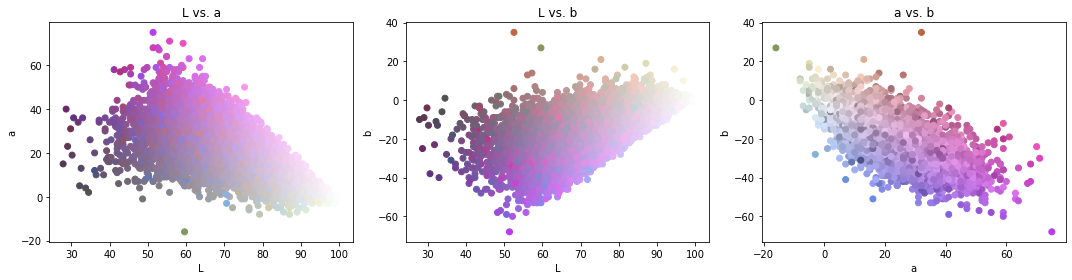

In [10]:
L, a, b = np.array(color_df_reduced[["L","a","b"]]).T

fig, axes = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)

axes[0].scatter(L, a, alpha=1,c=color_df_reduced.hex)
axes[0].set_xlabel('L'); axes[0].set_ylabel('a'); axes[0].set_title('L vs. a')

axes[1].scatter(L, b, alpha=1,c=color_df_reduced.hex)
axes[1].set_xlabel('L'); axes[1].set_ylabel('b'); axes[1].set_title('L vs. b')

axes[2].scatter(a, b, alpha=1,c=color_df_reduced.hex)
axes[2].set_xlabel('a'); axes[2].set_ylabel('b'); axes[2].set_title('a vs. b')

plt.savefig('../figures/figure_puzzling/lab_correlations.pdf',dpi=300)

plt.show()

### West

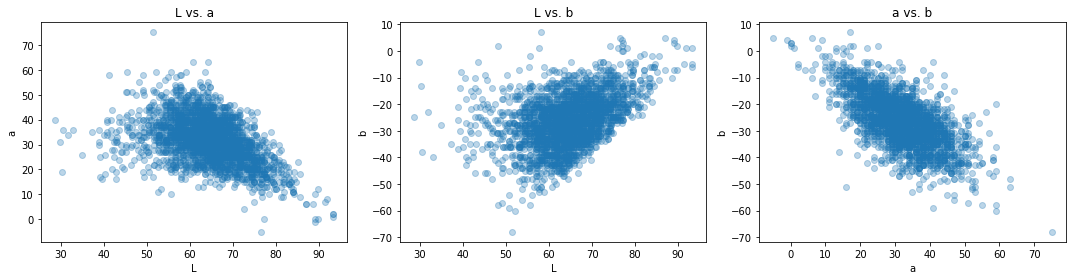

In [11]:
L, a, b = np.array(west_df[["L","a","b"]]).T

fig, axes = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)

axes[0].scatter(L, a, alpha=0.3)
axes[0].set_xlabel('L'); axes[0].set_ylabel('a'); axes[0].set_title('L vs. a')

axes[1].scatter(L, b, alpha=0.3)
axes[1].set_xlabel('L'); axes[1].set_ylabel('b'); axes[1].set_title('L vs. b')

axes[2].scatter(a, b, alpha=0.3)
axes[2].set_xlabel('a'); axes[2].set_ylabel('b'); axes[2].set_title('a vs. b')

plt.show()

### East

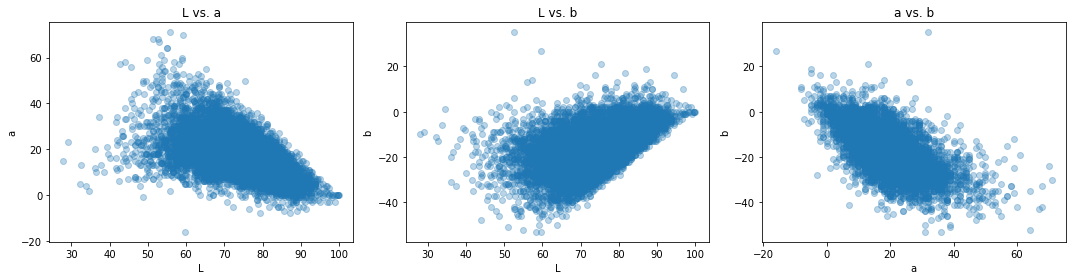

In [12]:
L, a, b = np.array(east_df[["L","a","b"]]).T

fig, axes = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)

axes[0].scatter(L, a, alpha=0.3)
axes[0].set_xlabel('L'); axes[0].set_ylabel('a'); axes[0].set_title('L vs. a')

axes[1].scatter(L, b, alpha=0.3)
axes[1].set_xlabel('L'); axes[1].set_ylabel('b'); axes[1].set_title('L vs. b')

axes[2].scatter(a, b, alpha=0.3)
axes[2].set_xlabel('a'); axes[2].set_ylabel('b'); axes[2].set_title('a vs. b')

plt.show()

# Re-do with LCh?

### All

In [13]:
lab_raw = color_df_reduced[["L", "a", "b"]].to_numpy().astype(float)

lab_true = lab_raw.copy()

lch_arr = np.empty_like(lab_true)
for i, (L_, a_, b_) in enumerate(lab_true):
    # had to think carefully here -- these look like the correct defaults
    # rather than d50 illuminant because of I used opencv at its default
    lab = LabColor(L_, a_, b_, observer='2', illuminant='d65') 
    lch = convert_color(lab, LCHabColor)
    lch_arr[i] = lch.get_value_tuple()

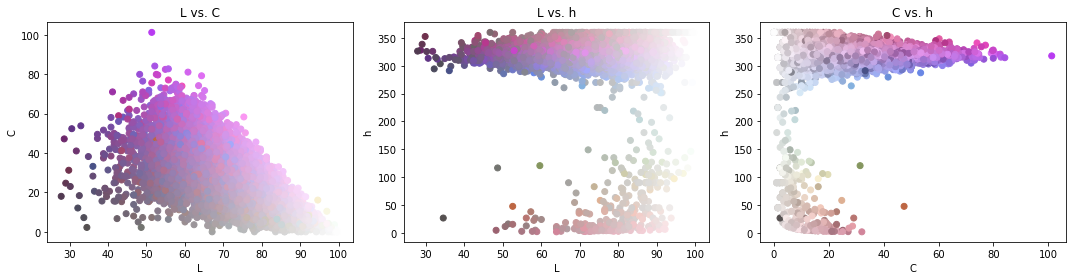

In [14]:
L, C, h = lch_arr.T

fig, axes = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)

axes[0].scatter(L, C, alpha=1,c=color_df_reduced.hex)
axes[0].set_xlabel('L'); axes[0].set_ylabel('C'); axes[0].set_title('L vs. C')

axes[1].scatter(L, h, alpha=1,c=color_df_reduced.hex)
axes[1].set_xlabel('L'); axes[1].set_ylabel('h'); axes[1].set_title('L vs. h')

axes[2].scatter(C, h, alpha=1,c=color_df_reduced.hex)
axes[2].set_xlabel('C'); axes[2].set_ylabel('h'); axes[2].set_title('C vs. h')

plt.savefig('../figures/figure_puzzling/lch_correlations.pdf',dpi=300)

plt.show()

In [15]:
color_df_reduced['lch_l'] = lch_arr[:,0]
color_df_reduced['lch_c'] = lch_arr[:,1]
color_df_reduced['lch_h'] = lch_arr[:,2]

# How many in hue range [260-360]?

In [16]:
in_purple_range = (color_df_reduced['lch_h'] >=260) & (color_df_reduced['lch_h'] <=360)
print(in_purple_range.sum() / len(in_purple_range))
print(in_purple_range.sum())
print(len(in_purple_range))

0.9817326822210165
16284
16587


### boxplots -- L

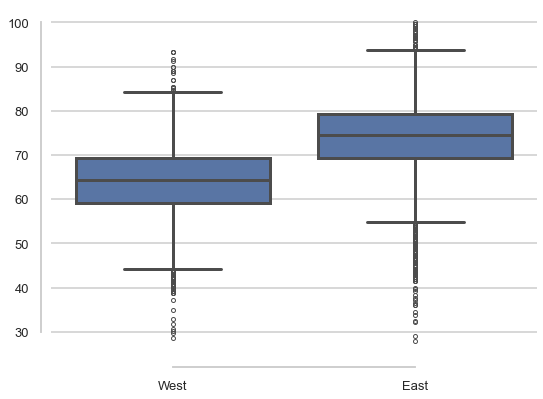

t-statistic: 53.785
p-value: 0.00000


In [17]:
# make nice figure aesthetics
sns.set(style='whitegrid', context='talk', font_scale=1.2)

# set up plot
fig, ax = plt.subplots(figsize=(8, 6))

# specify boxplot params
sns.boxplot(
    x='region',
    y='lch_l',
    data=color_df_reduced,
    #hue='region',
    legend=False,
    #palette=[west_median_color, east_median_color],  # two shades of purple. could be the same, no preference here.
    linewidth=3,
    fliersize=4,
    order=['West', 'East'],
    #hue_order=['West', 'East'],
    ax=ax
)

# no labels/titles
#ax.set_title('"Darkness" by Region (West vs. East)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel(None)
ax.set_ylabel(None)

# tick parameters
ax.tick_params(axis='both', which='major', labelsize=13)

# this helps push the horiz bars away from the y
sns.despine(offset=10, trim=True)

# let's see it!
plt.tight_layout()
#plt.savefig(f"../figures/figure3/box_whisker_a.pdf", dpi=300, bbox_inches="tight")
plt.show()

# t-test as well
west_darkness = color_df_reduced[color_df_reduced['region'] == 'West']['lch_l']
east_darkness = color_df_reduced[color_df_reduced['region'] == 'East']['lch_l']
t_stat, p_value = ttest_ind(east_darkness, west_darkness, equal_var=False)

# t-test results
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.5f}")

### boxplots -- C

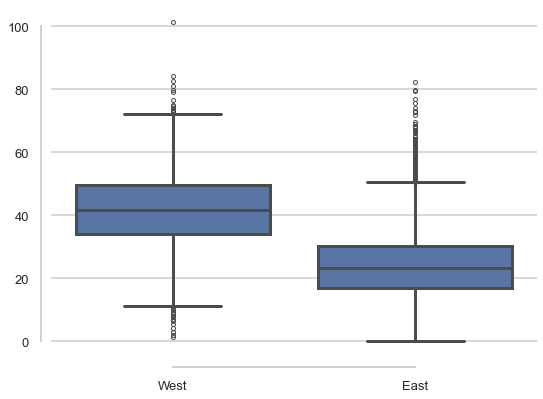

t-statistic: -68.206
p-value: 0.00000


In [18]:
# make nice figure aesthetics
sns.set(style='whitegrid', context='talk', font_scale=1.2)

# set up plot
fig, ax = plt.subplots(figsize=(8, 6))

# specify boxplot params
sns.boxplot(
    x='region',
    y='lch_c',
    data=color_df_reduced,
    #hue='region',
    legend=False,
    #palette=[west_median_color, east_median_color],  # two shades of purple. could be the same, no preference here.
    linewidth=3,
    fliersize=4,
    order=['West', 'East'],
    #hue_order=['West', 'East'],
    ax=ax
)

# no labels/titles
#ax.set_title('"Darkness" by Region (West vs. East)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel(None)
ax.set_ylabel(None)

# tick parameters
ax.tick_params(axis='both', which='major', labelsize=13)

# this helps push the horiz bars away from the y
sns.despine(offset=10, trim=True)

# let's see it!
plt.tight_layout()
#plt.savefig(f"../figures/figure3/box_whisker_a.pdf", dpi=300, bbox_inches="tight")
plt.show()

# t-test as well
west_darkness = color_df_reduced[color_df_reduced['region'] == 'West']['lch_c']
east_darkness = color_df_reduced[color_df_reduced['region'] == 'East']['lch_c']
t_stat, p_value = ttest_ind(east_darkness, west_darkness, equal_var=False)

# t-test results
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.5f}")

### boxplots -- h

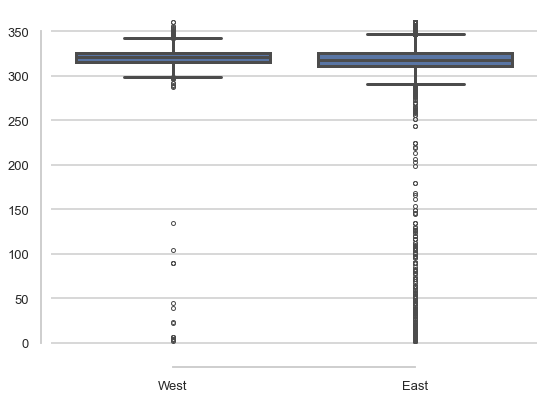

t-statistic: -8.758
p-value: 0.00000


In [19]:
# make nice figure aesthetics
sns.set(style='whitegrid', context='talk', font_scale=1.2)

# set up plot
fig, ax = plt.subplots(figsize=(8, 6))

# specify boxplot params
sns.boxplot(
    x='region',
    y='lch_h',
    data=color_df_reduced,
    #hue='region',
    legend=False,
    #palette=[west_median_color, east_median_color],  # two shades of purple. could be the same, no preference here.
    linewidth=3,
    fliersize=4,
    order=['West', 'East'],
    #hue_order=['West', 'East'],
    ax=ax
)

# no labels/titles
#ax.set_title('"Darkness" by Region (West vs. East)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel(None)
ax.set_ylabel(None)

# tick parameters
ax.tick_params(axis='both', which='major', labelsize=13)

# this helps push the horiz bars away from the y
sns.despine(offset=10, trim=True)

# let's see it!
plt.tight_layout()
#plt.savefig(f"../figures/figure3/box_whisker_a.pdf", dpi=300, bbox_inches="tight")
plt.show()

# t-test as well
west_darkness = color_df_reduced[color_df_reduced['region'] == 'West']['lch_h']
east_darkness = color_df_reduced[color_df_reduced['region'] == 'East']['lch_h']
t_stat, p_value = ttest_ind(east_darkness, west_darkness, equal_var=False)

# t-test results
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.5f}")

### West

In [20]:
lab_raw = west_df[["L", "a", "b"]].to_numpy().astype(float)

lab_true = lab_raw.copy()

lch_arr = np.empty_like(lab_true)
for i, (L_, a_, b_) in enumerate(lab_true):
    # had to think carefully here -- these look like the correct defaults
    # rather than d50 illuminant because of I used opencv at its default
    lab = LabColor(L_, a_, b_, observer='2', illuminant='d65') 
    lch = convert_color(lab, LCHabColor)
    lch_arr[i] = lch.get_value_tuple()

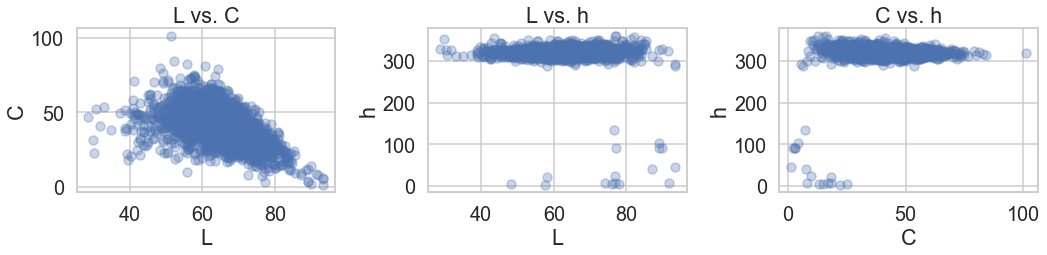

In [21]:
L, C, h = lch_arr.T

fig, axes = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)

axes[0].scatter(L, C, alpha=0.3)
axes[0].set_xlabel('L'); axes[0].set_ylabel('C'); axes[0].set_title('L vs. C')

axes[1].scatter(L, h, alpha=0.3)
axes[1].set_xlabel('L'); axes[1].set_ylabel('h'); axes[1].set_title('L vs. h')

axes[2].scatter(C, h, alpha=0.3)
axes[2].set_xlabel('C'); axes[2].set_ylabel('h'); axes[2].set_title('C vs. h')

plt.show()

### East

In [22]:
lab_raw = east_df[["L", "a", "b"]].to_numpy().astype(float)

lab_true = lab_raw.copy()

lch_arr = np.empty_like(lab_true)
for i, (L_, a_, b_) in enumerate(lab_true):
    # had to think carefully here -- these look like the correct defaults
    # rather than d50 illuminant because of I used opencv at its default
    lab = LabColor(L_, a_, b_, observer='2', illuminant='d65') 
    lch = convert_color(lab, LCHabColor)
    lch_arr[i] = lch.get_value_tuple()

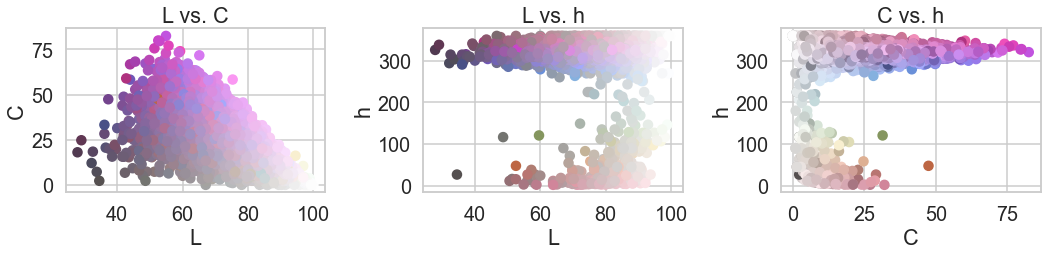

In [23]:
L, C, h = lch_arr.T

fig, axes = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)

axes[0].scatter(L, C, alpha=1,c=east_df.hex)
axes[0].set_xlabel('L'); axes[0].set_ylabel('C'); axes[0].set_title('L vs. C')

axes[1].scatter(L, h, alpha=1,c=east_df.hex)
axes[1].set_xlabel('L'); axes[1].set_ylabel('h'); axes[1].set_title('L vs. h')

axes[2].scatter(C, h, alpha=1,c=east_df.hex)
axes[2].set_xlabel('C'); axes[2].set_ylabel('h'); axes[2].set_title('C vs. h')

plt.show()

# What do the low h values look like?

In [24]:
lab_raw = color_df_reduced[["L", "a", "b"]].to_numpy().astype(float)

lab_true = lab_raw.copy()

lch_arr = np.empty_like(lab_true)
for i, (L_, a_, b_) in enumerate(lab_true):
    # had to think carefully here -- these look like the correct defaults
    # rather than d50 illuminant because of I used opencv at its default
    lab = LabColor(L_, a_, b_, observer='2', illuminant='d65') 
    lch = convert_color(lab, LCHabColor)
    lch_arr[i] = lch.get_value_tuple()

In [25]:
wonky_colors = color_df_reduced[lch_arr[:,2] < 250]
len(wonky_colors)

297

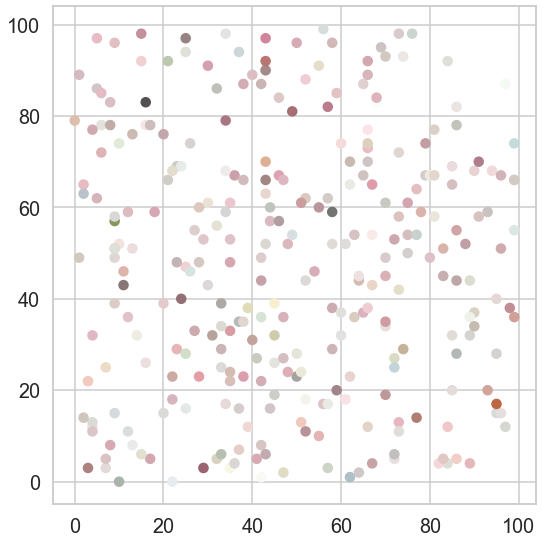

In [26]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)

axes.scatter(np.random.randint(0,100,len(wonky_colors)), np.random.randint(0,100,len(wonky_colors)), c=list(wonky_colors.hex))

plt.show()

# Plot 3D histograms to better capture density of purples relative to other outlier colors

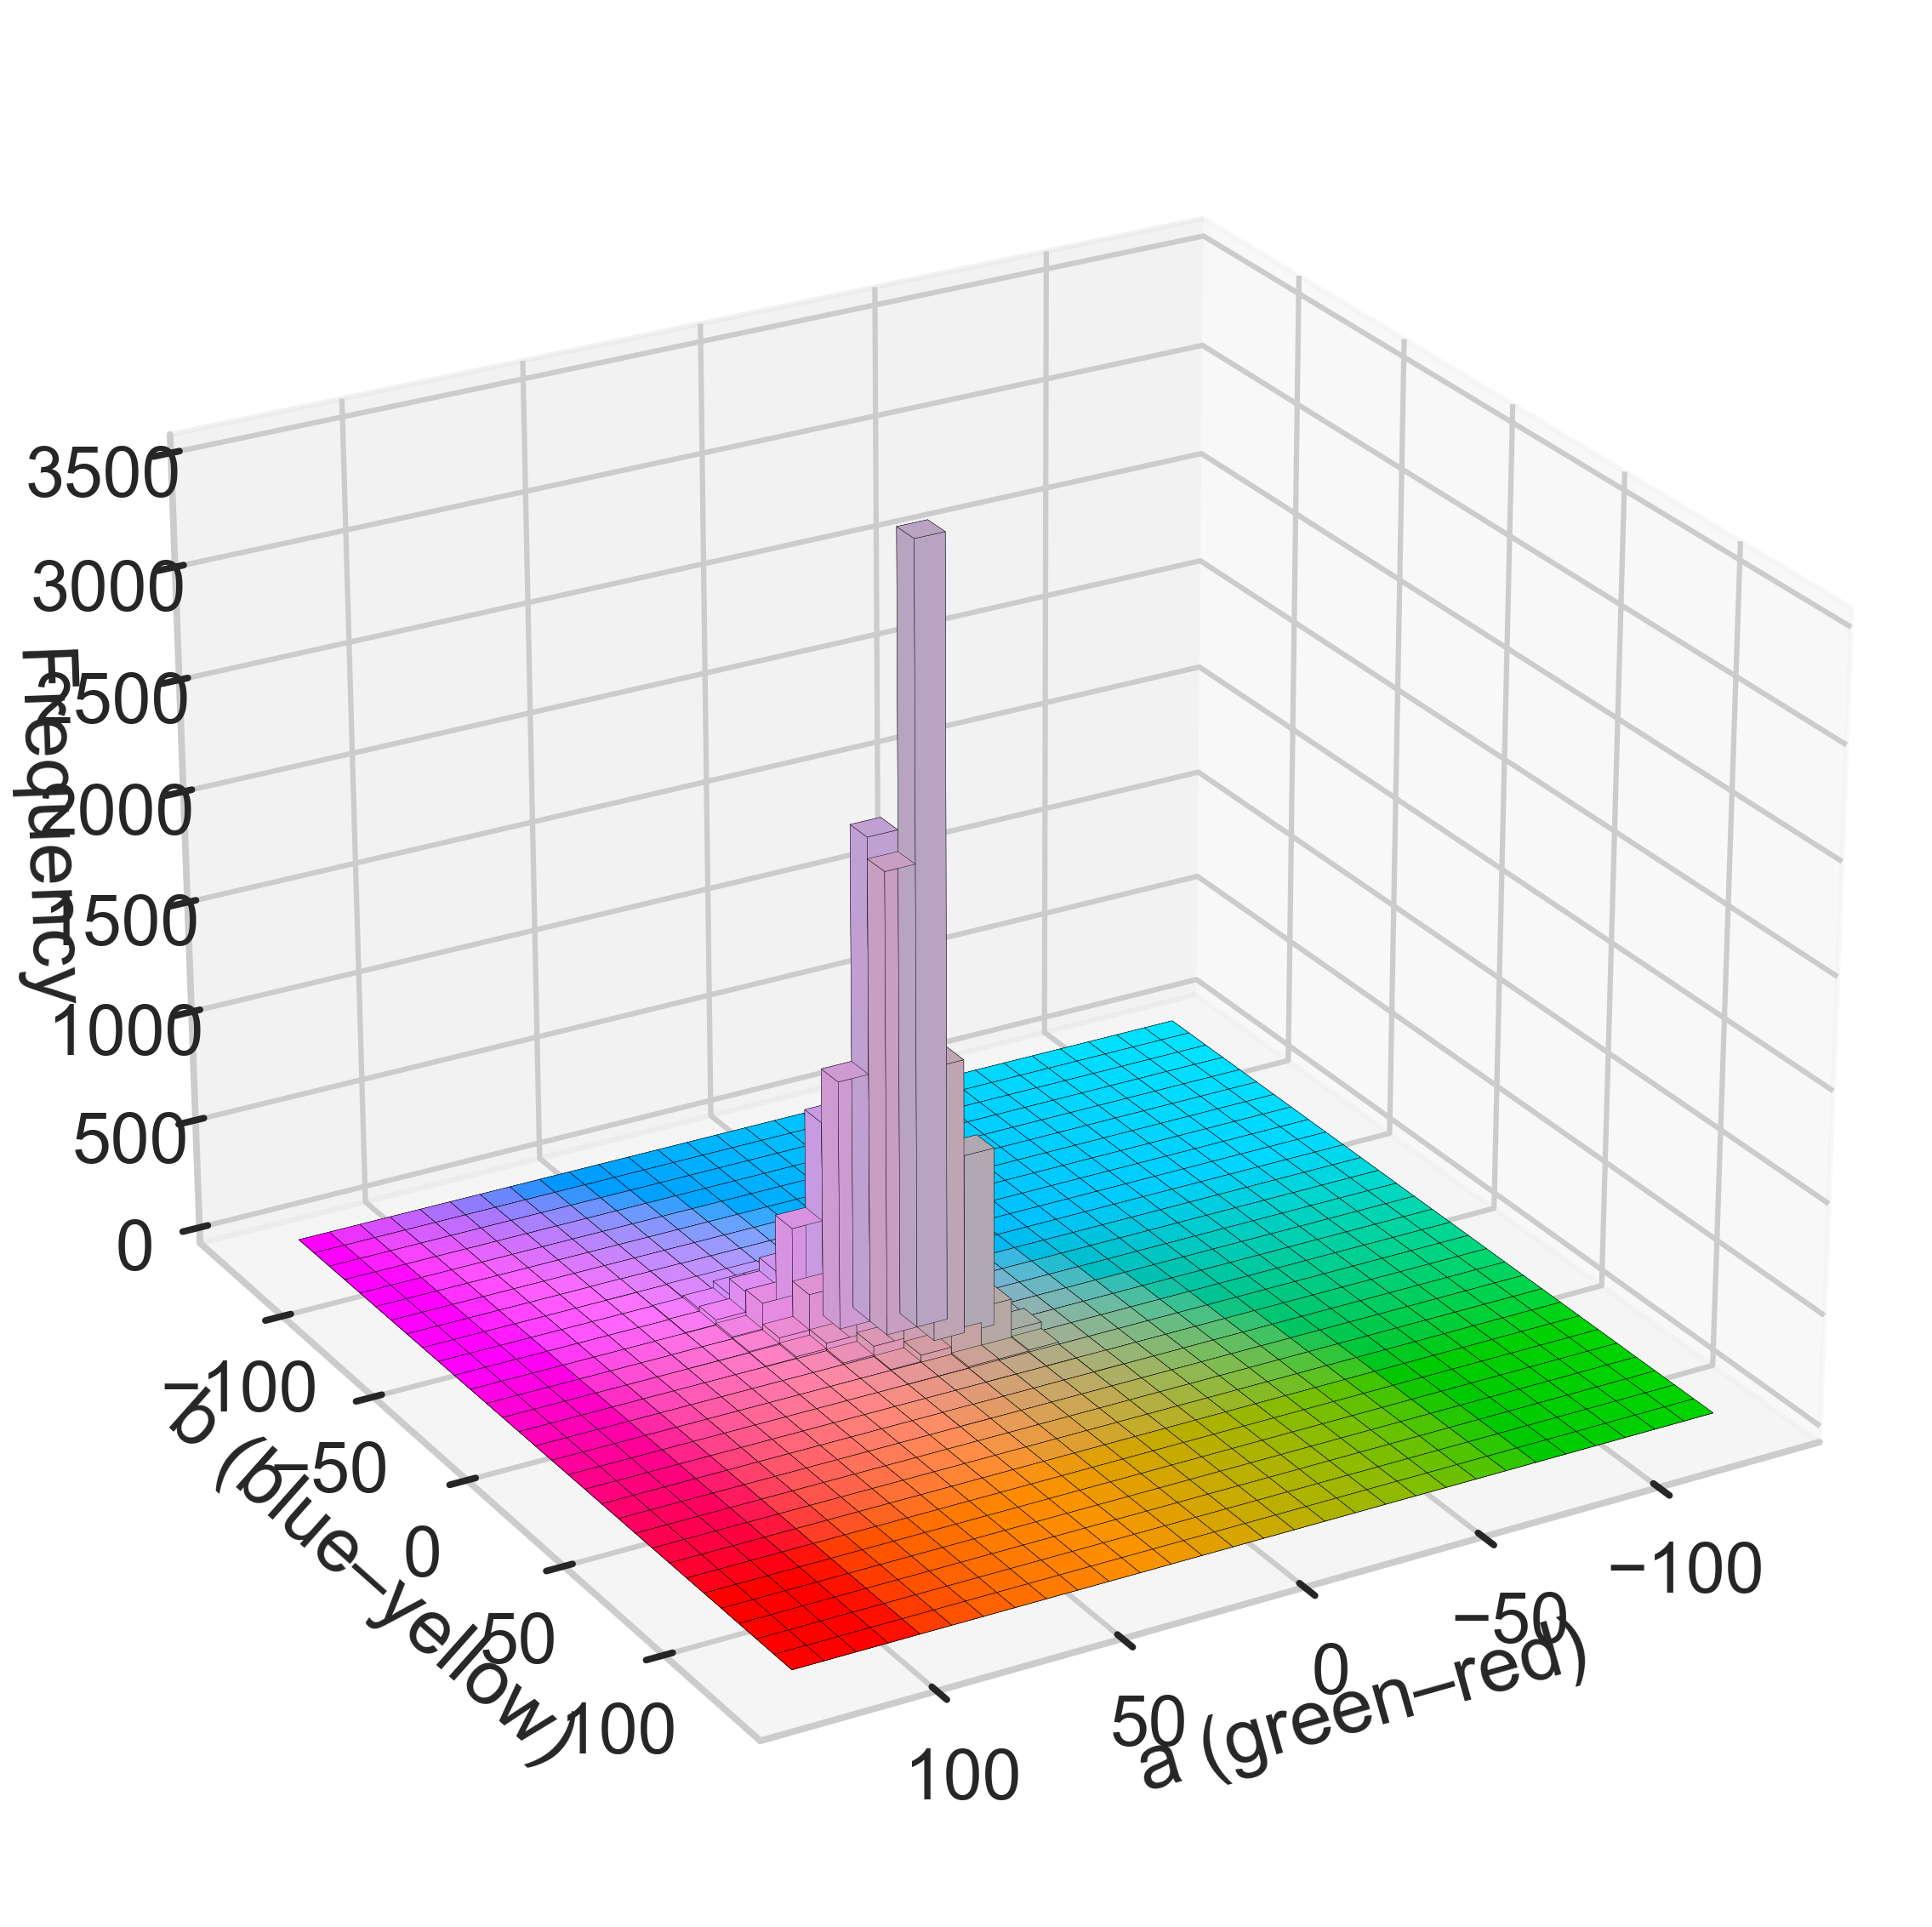

In [27]:
# bin definitions
num_x_bins = 30
num_y_bins = 30
# make the actual histogram object
hist, xedges, yedges = np.histogram2d(color_df_reduced['a'], color_df_reduced['b'], bins=[num_x_bins, num_y_bins],range=[[-128,128],[-128,128]])

# the the center of each bin
a_centers = (xedges[:-1] + xedges[1:]) / 2
b_centers = (yedges[:-1] + yedges[1:]) / 2

# pick a default L for all bins -- this is arbitrary -- we're just looking at hue differences here
default_L = 70#L.mean()

# build mean_lab grid
mean_lab = np.zeros((num_x_bins, num_y_bins, 3), dtype=float)
for i in range(num_x_bins):
    for j in range(num_y_bins):
        mean_lab[i, j] = [ default_L,
                           a_centers[i],
                           b_centers[j] ]

# convert entire grid to srgb.... I think  this is what bar3d is going to want
flat_rgb = lab2rgb(mean_lab[np.newaxis, ...]).reshape(-1, 3)

# line up all of our data
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')
xpos = xpos.ravel(); ypos = ypos.ravel()
#xpos = xpos.flatten(); ypos = ypos.flatten()
zpos = np.zeros_like(xpos)
dx = (xedges[1] - xedges[0]) * np.ones_like(zpos)
dy = (yedges[1] - yedges[0]) * np.ones_like(zpos)
dz = hist.ravel()

# plot
fig = plt.figure(figsize=(10, 8),dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz,
         color=flat_rgb,
         shade=False,
         edgecolor='black',
         linewidth=.1)

ax.set_xlabel('a (green–red)')
ax.set_ylabel('b (blue–yellow)')
ax.set_zlabel('Frequency')
ax.view_init(elev=25, azim=60)
plt.tight_layout()
plt.savefig('../figures/figure_puzzling/lab_3d_v1.pdf',dpi=300)
plt.show()

### rotate 180 degrees

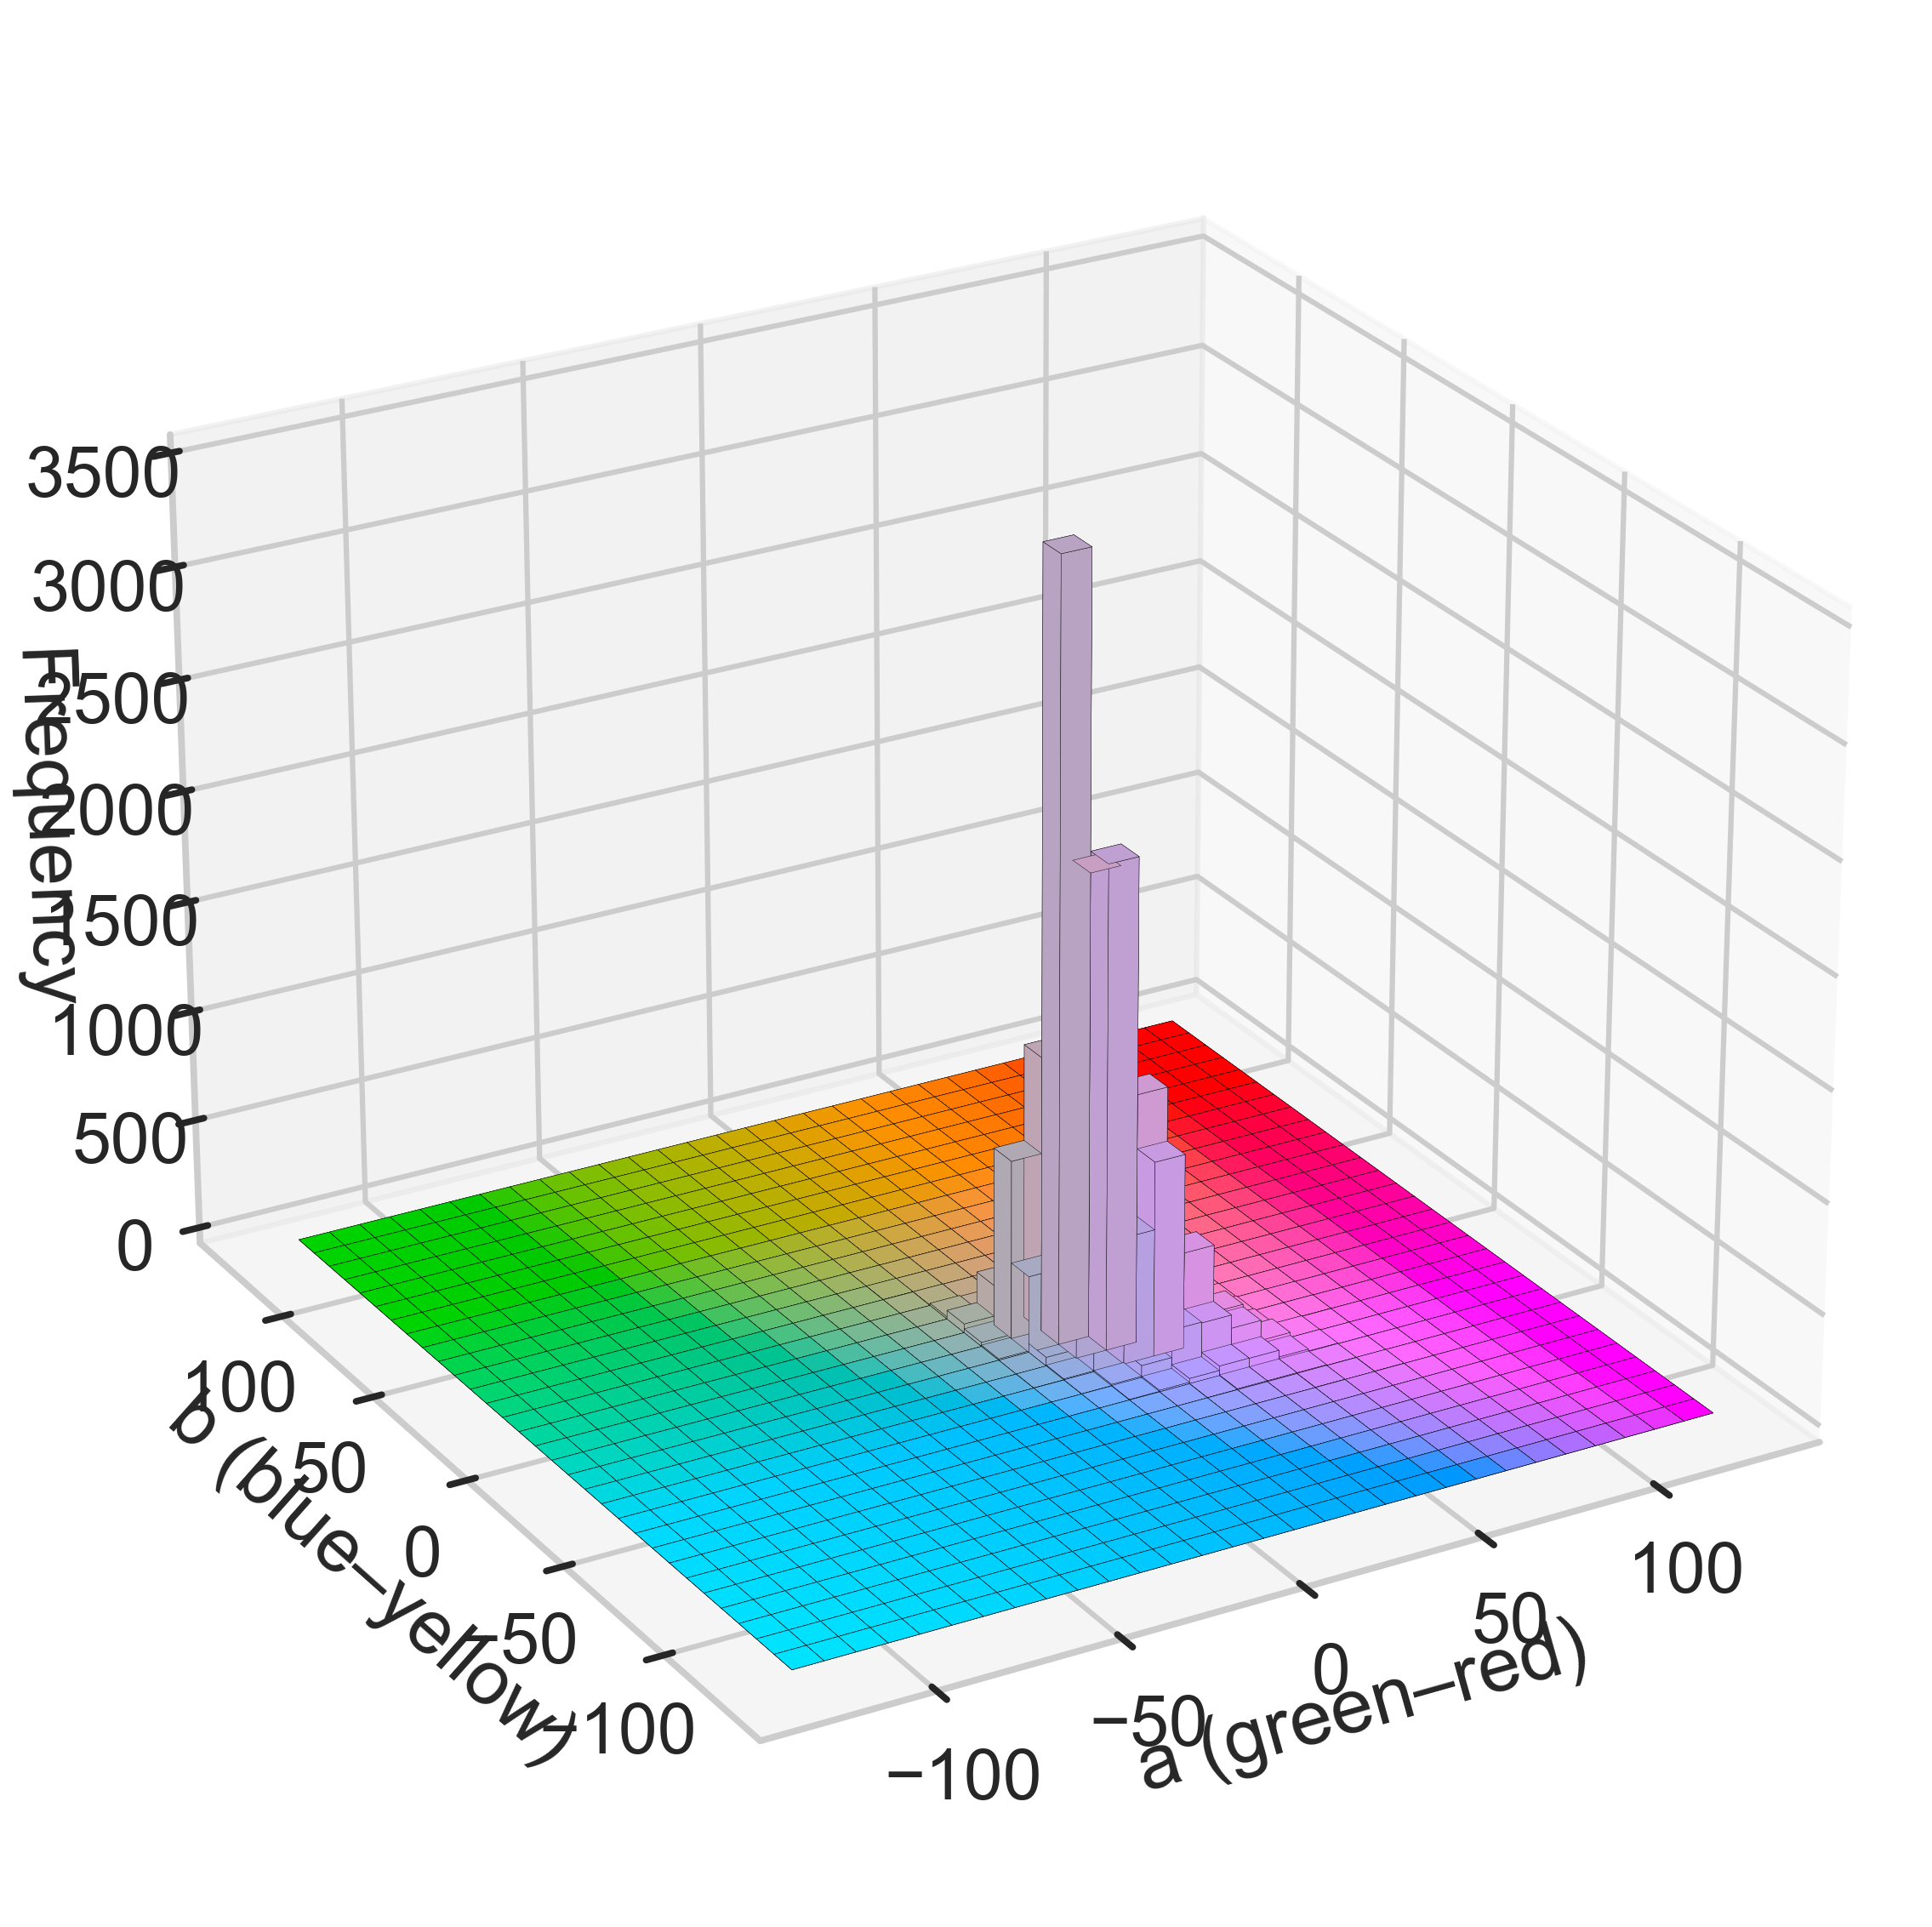

In [28]:
# bin definitions
num_x_bins = 30
num_y_bins = 30
# make the actual histogram object
hist, xedges, yedges = np.histogram2d(color_df_reduced['a'], color_df_reduced['b'], bins=[num_x_bins, num_y_bins],range=[[-128,128],[-128,128]])

# the the center of each bin
a_centers = (xedges[:-1] + xedges[1:]) / 2
b_centers = (yedges[:-1] + yedges[1:]) / 2

# pick a default L for all bins -- this is arbitrary -- we're just looking at hue differences here
default_L = 70#L.mean()

# build mean_lab grid
mean_lab = np.zeros((num_x_bins, num_y_bins, 3), dtype=float)
for i in range(num_x_bins):
    for j in range(num_y_bins):
        mean_lab[i, j] = [ default_L,
                           a_centers[i],
                           b_centers[j] ]

# convert entire grid to srgb.... I think  this is what bar3d is going to want
flat_rgb = lab2rgb(mean_lab[np.newaxis, ...]).reshape(-1, 3)

# line up all of our data
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')
xpos = xpos.ravel(); ypos = ypos.ravel()
#xpos = xpos.flatten(); ypos = ypos.flatten()
zpos = np.zeros_like(xpos)
dx = (xedges[1] - xedges[0]) * np.ones_like(zpos)
dy = (yedges[1] - yedges[0]) * np.ones_like(zpos)
dz = hist.ravel()

# plot
fig = plt.figure(figsize=(10, 8),dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz,
         color=flat_rgb,
         shade=False,
         edgecolor='black',
         linewidth=.1)

ax.set_xlabel('a (green–red)')
ax.set_ylabel('b (blue–yellow)')
ax.set_zlabel('Frequency')
ax.view_init(elev=25, azim=240)
plt.tight_layout()
plt.savefig('../figures/figure_puzzling/lab_3d_v2.pdf',dpi=300)
plt.show()